# Viscoelastic Earthquake Cycles (semi-analytical solve)
In this notebook we will show how we can exploit boundary element calculations to run viscoelastic earthquake calculations. The premise is that once we construct a displacement and stress interaction kernel i.e., a function that relates slip on any point on a fault or inelastic strain at any location in the viscoelastic bulk to displacements and stress change everywhere else respectively, all the expensive computations are done! To understand the method we start with the simplest case of a spring-dashpot (without any physical dimensions to the problem) 

## Spring-dashpot (Linear Maxwell rheology)
In a spring-dashpot system in series, we consider a rheology where strains are additive i.e., 
$$
\epsilon = \epsilon_e + \epsilon_v
$$
where $\epsilon_e$ is the elastic component and $\epsilon_v$ is the viscous component. For a Maxwell body, stress is common to the elastic and viscous elements i.e.,
$$
\sigma = \mu\epsilon_e = \eta\dot{\epsilon}_v
$$

The above equation can be differentiated w.r.t time to give us the governing ordinary differential equation (ODE) for the system: 
$$
\mu\left(\dot{\epsilon} - \dot{\epsilon}_v\right) = \eta\frac{\mathrm{d}\dot{\epsilon}_v}{\mathrm{d}t}
$$

In the case of a tectonic plate boundary we know it is driven in the long-term by plate driving forces that result in long-term viscous strain $\dot{\epsilon}^{\infty}$. Substituting this gives us,
$$
\mu\left(\dot{\epsilon}^{\infty} - \dot{\epsilon}_v\right) = \eta\frac{\mathrm{d}\dot{\epsilon}_v}{\mathrm{d}t}
$$

## 2-d Linear Maxwell rheology
The role of the stress interaction kernel is highlighted when we bring in physical dimensions to the problem. Due to the non-local nature of elastic interactions, we need to replace the elastic modulus $\mu$ with $K(x_o;x_s)$ where $x_o,x_s$ are observation and source location combinations respectively. Instead of an ODE, we now have a coupled system of ODEs
$$
\frac{\mathrm{d}\dot{\epsilon}_v(\mathbf{x},t)}{\mathrm{d}t} = \frac{K(\mathbf{x};\mathbf{x})}{\eta(\mathbf{x})}\left(\dot{\epsilon}^{\infty}(\mathbf{x}) - \dot{\epsilon}_v(\mathbf{x},t)\right).
$$
subject to an initial condition $\dot{\epsilon}_v(\mathbf{x},t = 0)$. 

We note that in 2-d, $\dot{\epsilon}_v(\mathbf{x},t)$ varies in both space and time, and is not a scalar value but is a vector of deviatoric strain rates.

## Semi-analytical solution
This system of equations can be solved semi-analytically using an eigen-decomposition of $\frac{K}{\eta} = T\Lambda T^{-1}$, which gives us the solution:

$$
\dot{\epsilon}_v(\mathbf{x},t) = T \cdot e^{\Lambda t} \cdot T^{-1}\cdot \left(\dot{\epsilon}_v(\mathbf{x},0) - \dot{\epsilon}^{\infty}(\mathbf{x})\right) + \dot{\epsilon}^{\infty}(\mathbf{x})
$$

This framework can be modified to also include faults if we transform frictional properties into an equivalent viscosity term. In the subsequent sections we show how to use `I2EC` functions to carry out this task. As part of the process, we also need to spin-up the earthquake cycles to get cycle-invariant results i.e., no dependence on the guess we make for initial conditions. This is important because the way we impose $\dot{\epsilon}_v(\mathbf{x},t = 0)$ is in terms of a change relative to a pre-earthquake strain rate. Typically most models either ignore this effect, or will just run the earthquake cycles a sufficient number of times till spin-up is achieved by brute force. In our approach we will analytically derive a self-consistently spun-up initial condition for $\dot{\epsilon}_v(\mathbf{x},t = 0)$.

First let us set up some preliminary quantities that describe: 
1. Elastic properties of the medium, 
2. Relative plate motion 
3. Earthquake recurrence interval (this also becomes the coseismic slip distribution)

In [1]:
clear  
addpath functions/
import('geometry.*')

% Elastic parameters (homogenous medium)
nu=0.25;% Poisson's ratio
mu=30e3;% in MPa

% Periodic earthquake recurrence time
Trecur = 500*3.15e7;% in seconds
Vpl = 1e-9;% m/s

% max coseismic stress change on fault (MPa): we use this as a threshold value
tau_max = 3;

# Read files and load/compute kernels

The meshes are each stored as objects of the class `geometry` as follows:
- `rcv` - megathrust mesh with elasto-frictional rheology using `geometry.receiver`
- `shz` - shear zone mesh with visco-elastic rheology using `geometry.shearZoneReceiver`
- `boundary` - simply connected line mesh (not including topography) for the lateral and bottom boundaries (prescribe Dirichlet/Neumann conditions) using `geometry.receiver`

The stress kernels are stored in the data structure `evl`, which contains the following matrices
1. KK - `rcv`-`rcv` interactions with dimensions [`rcv.N` x `rcv.N`]
2. KL - `rcv`-`shz` interactions [`shz.N` x `rcv.N` x 2] (2 components for observations - each deviatoric $\sigma$ component)
3. LK - `shz`-`rcv` interactions [`rcv.N` x `shz.N` x 2] (2 components for source - each deviatoric $\epsilon_v$ component)
4. LL - `shz`-`shz` interactions [`shz.N` x `shz.N` x 2 x 2]


In [2]:
%% load fault, boundary and shear zone meshes
earthModel = geometry.LDhs(mu,nu);

rcv = geometry.receiver('inputs/megathrust2d.seg',earthModel);

% boundary mesh
boundary = geometry.receiver('inputs/boundary2d.seg',earthModel);
boundary.Vx = boundary.Vx.*Vpl;
boundary.Vz = boundary.Vz.*Vpl;

% provide shear zone mesh as 2 .dat files of the form
% meshname_vertices.dat (contains x,z coordinates of vertices)
% meshname_triangulation.dat (contains 3 columns of vertex linkage)
% This mesh can be created using CREATE_shearzone_mesh.m provided in the
% folder 'meshing'
shz = geometry.shearZoneReceiver('inputs/shearzone',earthModel);

% compute stress interaction kernels
if exist('kernels/evl_orig.mat') % load kernels if they exist    
    load('kernels/evl_orig.mat','evl_orig');
else
    evl_orig = computeAllStressKernelsBem(rcv,shz,boundary,'kernelmodify',0);
end
% compute displacement kernels
Nobs = 401;
obs = ([1;0]*(linspace(-100,500,Nobs)))'*1e3;
if exist('kernels/devl.mat')
    load('kernels/devl.mat','devl');
else
    devl = computeAllDisplacementKernelsBem(obs,rcv,shz,boundary,1);
end

# Assign viscous material properties to `rcv` and `shz`
- Note that the viscosity of a fault patch is actually viscosity per unit length i.e., $\eta' = \frac{\eta}{L}$. We wrote this code to handle rate-dependent friction initially so the property associated with rheology in `rcv` is called `rcv.Asigma` (the more popular way is to call it $(a-b)\sigma_n$ in rate-dependent friction)
- For the oceanic & continental mantle one can vary the viscosity arbitrarily in space, but in this case we chose depth-dependent and laterally varying viscosities respectively. 
- Instead of viscosity $\eta$, we store the fluidity $\alpha = \frac{1}{\eta}$ in `shz.alpha`. 
- Additionally, the code is built to handle arbitrary power-law parameters, so one must also make sure `shz.n = ones(shz.N,1)` for all elements.

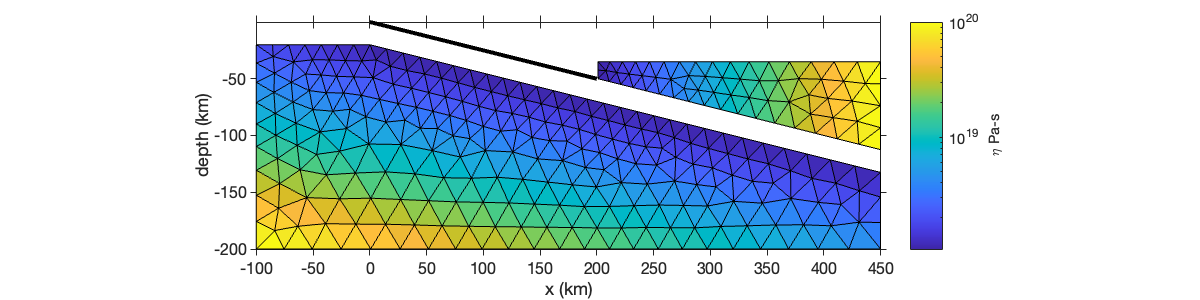

In [3]:
% approximate fault by a viscous shear zone 
% (a-b)sigma in terms of viscosity
% eta' = viscosity/L_fault
rcv.Asigma = 1e-6.*(1e18/(sum(~rcv.pinnedPosition.*rcv.W))).*ones(rcv.N,1);

%%%%%%% oceanic mantle viscosity structure %%%%%%%
r = abs(tand(rcv.dip(1)).*shz.xc(:,1) + shz.xc(:,2) + 20e3)./sqrt(tand(rcv.dip(1))^2 + 1);
r = r./max(r);% normalize to 0->1
viscostructure = 10.^(18 + r.*2);
shz.n = ones(shz.N,1);
shz.alpha = 1./(viscostructure.*1e-6);
oceanic_mantle = (shz.xc(:,1) < -shz.xc(:,2)/tand(rcv.dip(1)));

%%%%%%% continental mantle viscosity structure %%%%%%%
r = sqrt((shz.xc(~oceanic_mantle,1)-200e3).^2);
r = r./max(r);% normalize to 0->1
viscostructure = 10.^(18 + r.*2);
shz.alpha(~oceanic_mantle) = 1./(viscostructure.*1e-6);

% define locked zone on megathrust
locked = abs(rcv.xc(:,2)) > 0e3 & abs(rcv.xc(:,2))< 30e3;
rcv.pinnedPosition = locked;

% define long-term slip/strain rates
rcv.Vpl = Vpl.*ones(rcv.N,1);% m/s

figure(1),clf
set(gcf,'Position',[0 0 6 1.5]*100)
plotpatch2d(rcv), hold on
plotshz2d(shz,1e6./(shz.alpha))
axis tight equal, box on
colormap(parula)
cb=colorbar; cb.Label.String = '\eta Pa-s';
xlabel('x (km)'), ylabel('depth (km)')
set(gca,'ColorScale','log','FontSize',8,'LineWidth',0.5,'TickDir','both')

# Long-term and interseismic steady-state viscous strain rates
The long-term viscous strain rates $\dot{\epsilon}_v^{\infty}(\mathbf{x})$ is computed either analytically or numerically assuming: 
1. The fault is sliding at the full inter-plate velocity $v_{pl}$
2. The viscosity structure $\eta(\mathbf{x})$ is as prescribed in `rcv` and `shz`
3. The governing partial differential equation (PDE) is $\nabla \cdot \sigma'(\mathbf{x}) = 0$, where $\sigma(\mathbf{x}) = \eta(\mathbf{x})\dot{\epsilon}_v^{\infty}(\mathbf{x})$ i.e., a purely viscous rheology, the elastic layer at this timescale beyonds a rigid body.

In this code we use analytical solutions from Turcotte & Schubert [2002] to solve the governing PDE, but it can be easily replaced with any standard numerical approach. However, there is a second part to this problem: the effect of interseismic fault locking!

## Interseismic locking
When a part of the fault is locked interseismically, calculations of $\dot{\epsilon}_v^{\infty}(\mathbf{x})$ are deviated significantly. We account for this modified $\dot{\epsilon}_v^i(\mathbf{x}) \neq \dot{\epsilon}_v^{\infty}(\mathbf{x})$ by solving an associated elastic static boundary-value problem i.e, we solve for a fully relaxed interseismic viscoelastic system ($t \to \infty$), or in other words we solve for a new quasi-static steady state. If the fault was freely creeping, then the new strain rates would be exactly the same as $\dot{\epsilon}_v^{\infty}(\mathbf{x})$. However, since at least a part of the fault is locked, the resulting slip velocity on the unlocked fault and viscous strain rate in the bulk is calculated by 
$$
\require{cancel}
\cancelto{0}{\frac{d}{dt}\begin{bmatrix} v \\ \dot{\epsilon}_v \end{bmatrix}} = \frac{1}{\eta}\left(K\cdot\begin{bmatrix} v^i - v_{pl} \\ \dot{\epsilon}_v^i - \dot{\epsilon}_v^{\infty} \end{bmatrix}\right)
$$
subject to $v^i(\mathbf{x}_f) = 0$ where $\mathbf{x}_f \in \mathbf{x}$ refers to the locked fault domain while the set of unlocked and creeping locations is denoted by  $\mathbf{x}_i$ where $\mathbf{x} =\mathbf{x}_f \cup \mathbf{x}_i$. The kernel in the above equation can be written in terms of the imposed locking and creeping kernels as follows:
$$
0 = \begin{bmatrix} I_{N_f\times N_f} & 0 \\ K(\mathbf{x}_i;\mathbf{x}_f) & K(\mathbf{x}_i;\mathbf{x}_i) \end{bmatrix}\cdot\begin{bmatrix} v^i(\mathbf{x}_f) \\ v^i(\mathbf{x}_i),\dot{\epsilon}_v^i(\mathbf{x}_i)\end{bmatrix}
$$

$$
0 = K(\mathbf{x}_i;\mathbf{x}_i) \cdot\begin{bmatrix} v^i(\mathbf{x}_i) \\ \dot{\epsilon}_v^i(\mathbf{x}_i)\end{bmatrix} 
- K(\mathbf{x}_i;\mathbf{x}) \cdot \begin{bmatrix} v_{pl}(\mathbf{x}_f \cup \mathbf{x}_i) \\ \dot{\epsilon}_v^{\infty}(\mathbf{x})\end{bmatrix}
$$

However, it turns out the matrix $K(\mathbf{x}_i;\mathbf{x}_i)$ is singular and inverting it is not straightforward. To overcome this issue, we regularize the total solution length (Tikhonov 0<sup>th</sup> order). These calculations are done in `computeInterseismicSteadystate()`.

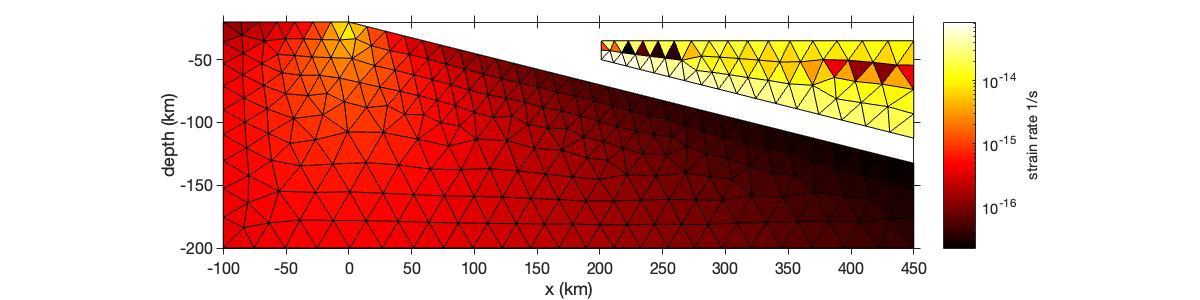

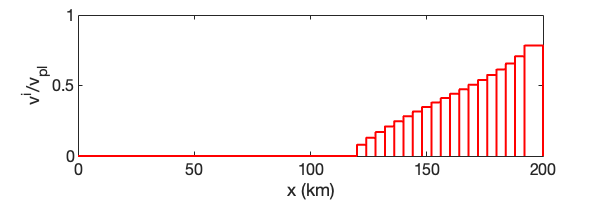

In [4]:
% compute steady state interseismic slip rate & strain rates
[v_ss,e22_ss,e23_ss] = computeInterseismicSteadystate(rcv,shz,evl_orig,Vpl,10);

% Long-term strain rate calculation
[e22_dev_lt, e23_lt] = getStrainratesLongterm(shz,rcv.dip(1)*pi/180,[0,20e3],[-140e3,35e3]);
shz.e22pl = e22_dev_lt.*Vpl;% 1/s
shz.e23pl = -e23_lt.*Vpl;% 1/s

% plot viscous strain rates (long-term)
figure(1),clf
set(gcf,'Position',[0 0 6 1.5]*100)
plotshz2d(shz,sqrt(shz.e22pl.^2 + shz.e23pl.^2))
% plotshz2d(shz,sqrt(e22_ss.^2 + e23_ss.^2))
axis tight equal, box on
cb=colorbar; cb.Label.String = 'strain rate 1/s';
xlabel('x (km)'), ylabel('depth (km)')
colormap(hot)
set(gca,'ColorScale','log','FontSize',8,'LineWidth',0.5,'TickDir','both')

% plot interseismic fault slip rate
figure(2),clf
set(gcf,'Position',[0 0 3 1]*100)
for i = 1:rcv.N
    plot([(rcv.xc(i,1)-rcv.W(i)/2*cosd(rcv.dip(i))).*[1 1],(rcv.xc(i,1)+rcv.W(i)/2*cosd(rcv.dip(i))).*[1 1]]./1e3, v_ss(i)./Vpl.*[0 1 1 0],'r-','LineWidth',1), hold on
end
xlabel('x (km)'), ylabel('v^i/v_{pl}')
ylim([0 1])
set(gca,'FontSize',8,'LineWidth',0.5)

# Compute coseismic slip distribution ($s_{co}$) $\to$ stress change ($\Delta\tau_{co}$)

In the simplest case, the spin-up cycles and the actual event for which we have a kinematically estimated slip distribution are identical - it is simply a characteristic-type box-car function of space with the amplitude exactly equal to the slip deficit over the recurrence interval $T_r$ (`Trecur`) i.e., 
$$
\begin{equation}
s=\begin{cases}
v_{pl}T_r, & \mathbf{x}_f \\ 
0, & \text{otherwise}
\end{cases}
\end{equation}
$$

Using the precomputed stress kernels, we can now convert $s_{co} \to \Delta\tau_{co}(\mathbf{x})$

In [5]:
% calculate coseismic stress change - imposed periodically
Nevents = 1; % N = 1 indicates a characteristic earthquake
slip_coseismic = zeros(rcv.N,Nevents) + Trecur*Vpl.*(locked);

% initialise stress change data structure
stress_change = [];
stress_change.Nevents = Nevents;
stress_change.Timing = 1;% provide timing as a non-zero value (in seconds since Trecur)
assert(length(stress_change.Timing) == Nevents)

stress_change.dtau = zeros(rcv.N,stress_change.Nevents);
stress_change.dsigma22 = zeros(shz.N,stress_change.Nevents);
stress_change.dsigma23 = zeros(shz.N,stress_change.Nevents);

% stress change for each event stored as a matrix
for i = 1:stress_change.Nevents
    dtau = evl_orig.KK*slip_coseismic(:,i);
    dtau(dtau > tau_max) = tau_max;
    stress_change.dtau(:,i) = dtau;
    stress_change.dtau(locked,i) = 0;% force stress change in coseismic region to 0

    stress_change.dsigma22(:,i) = evl_orig.KL(:,:,1)*slip_coseismic(:,i);
    stress_change.dsigma23(:,i) = evl_orig.KL(:,:,2)*slip_coseismic(:,i);
end

# Eigen-value decomposition
Use the precomputed stress kernel in `evl` and viscosity distribution stored in `rcv.Asigma` & `shz.alpha`, we construct the rheological parameter $\frac{K}{\eta}$ that controls the dynamics of the mechanical system - `rheoparam`. By decomposing `rheoparam` into associated eigen-vectors and eigen-values, and using the initial condition `deltastrainrate` $\left(\Delta\dot{\epsilon}_v(\mathbf{x},0) = \frac{\Delta\tau_{co}(\mathbf{x})}{\eta}\right)$, we can now predict the time dynamics of this system.

We note here that there is a issue with BEM kernels that requires special handling: singularities associated with the construction of the deviatoric stress kernels lead to positive eigen values. This is a problem because for any $\lambda \gt 0$, the solution $\exp\left(\lambda t\right)$ will lead to a growing instability! This is at odds with the physics of the problem, where $\frac{K}{\eta}$ represents a damped system decaying any initial perturbation to its steady state. To remedy this issue, we ad-hoc remove all positive eigen-values in the stress kernel. And it turns out on closer inspection, that the positive eigen values are associated with spatial scales comparable with the mesh size. So, these regularized stress kernels are appropriate for any smoothly varying strain rate field, which is the situation relevant to our problem.

In [6]:
%% construct stress interaction kernel (use unmodified stress kernel for interseismic calculation)
stresskernel = [evl_orig.KK(~locked,~locked),  evl_orig.LK(~locked,:,1),   evl_orig.LK(~locked,:,2);...
                     evl_orig.KL(:,~locked,1),      evl_orig.LL(:,:,1,1),       evl_orig.LL(:,:,1,2);...
                     evl_orig.KL(:,~locked,2),      evl_orig.LL(:,:,2,1),       evl_orig.LL(:,:,2,2)];

viscosityvector = [rcv.Asigma(~locked);1./shz.alpha;1./shz.alpha];
Nvec = length(viscosityvector);

rheoparam = stresskernel./repmat(viscosityvector,1,Nvec);

% eigenvector decomposition
[Evector,Evals] = eig(rheoparam);
% store eigenvalues in a vector
lambda = diag(Evals);
% remove positive eigen values
lambda_positive = (real(lambda) >= 0);
lambda(lambda_positive) = -Inf;

% combine all stress change into a single vector that captures coseismic
% strain rate change
deltastrainrate = [stress_change.dtau(~locked);stress_change.dsigma22;stress_change.dsigma23]./viscosityvector;

% long-term steady state strain rates
longterm_ss = [v_ss(~locked);e22_ss;e23_ss];

% compute late interseismic strain rates and initial conditions
sol_interseismic = real((eye(Nvec) - Evector*diag(exp(lambda.*Trecur))/Evector)\...
            (Evector*diag(exp(lambda.*Trecur))/Evector*(deltastrainrate-longterm_ss) + longterm_ss));


sol_initial = sol_interseismic + deltastrainrate;

# Evaluate solution at prescribed time steps

In [7]:
% tvec = [30,365,5*365].*86400;% seconds
% tvec = [5,10,15,20,50,100].*3.15e7;
tvec = [[10,365,1500,7000].*86400, Trecur];

slip = zeros(rcv.N,length(tvec));
e22 = zeros(shz.N,length(tvec));
e23 = zeros(shz.N,length(tvec));

V = zeros(rcv.N,length(tvec));
e22dot = zeros(shz.N,length(tvec));
e23dot = zeros(shz.N,length(tvec));

for i = 1:length(tvec)
    tval = tvec(i);
    % time-integrate dynammics
    sol = real(Evector*diag(exp(lambda.*tval))/Evector*(sol_initial-sol_interseismic)) + ...
               sol_interseismic;
    % extract solution to velocity & strainrate components
    V(~locked,i) = sol(1:length(find(~locked)));
    e22dot(:,i) = sol(length(find(~locked))+1:length(find(~locked))+shz.N);
    e23dot(:,i) = sol(length(find(~locked))+shz.N+1:end);

    % double integrated
    lambda_integrated = (exp(lambda.*tval) - ones(Nvec,1))./lambda;
    lambda_integrated(lambda_positive) = 0;
    sol = real(Evector*diag(lambda_integrated)/Evector*(sol_initial-sol_interseismic)) + ...
               sol_interseismic.*tval;
    
    % extract solution to slip & strain components
    slip(~locked,i) = sol(1:length(find(~locked)));
    e22(:,i) = sol(length(find(~locked))+1:length(find(~locked))+shz.N);
    e23(:,i) = sol(length(find(~locked))+shz.N+1:end);
end

# Plot surface displacements and velocities at various times

For surface displacement and velocity calculations, there is an additional step. For subduction zones, a significant chunk of the mechanical energy budget is related to plate bending and assocaited non-elastic deformation. The trouble is we don't actually what the rheology of this material is and so avoid modelling it. However, in the late interseismic period it is been shown that there can be a measurably different velocity field if stresses associated with plate bending are released continuously (through creep) or episodically in earthquakes. In our model, we approximate the effect of the plate bending using a 'hinge' fault, which is a vertical dip-slip fault. Note that the hinge is not part of the system of equations to model the mechanical system, but is a purely kinematic tool.

## Late interseismic surface velocity field

In [ ]:
% surface displacements and velocities
% calculate displacement time series at select observation points

hinge = geometry.receiver('inputs/hinge2d.seg',earthModel);
[Gx_d,Gz_d] = computeFaultDisplacementKernelsBem(hinge,obs,boundary,1);

fullsol_interseismic = [zeros(length(find(locked)),1);sol_interseismic] - [rcv.Vpl;shz.e22pl;shz.e23pl];
vx_int = [devl.KO(:,:,1),devl.LO(:,:,1,1),devl.LO(:,:,1,2)]*fullsol_interseismic - Gx_d * (hinge.Vpl.*Vpl); 
vz_int = [devl.KO(:,:,2),devl.LO(:,:,2,1),devl.LO(:,:,2,2)]*fullsol_interseismic - Gz_d * (hinge.Vpl.*Vpl); 

figure(1),clf
plot(obs(:,1)./1e3,vx_int./Vpl,'LineWidth',2), hold on
plot(obs(:,1)./1e3,vz_int./Vpl,'LineWidth',2)
axis tight,grid on
ylim([-1 1])
legend('horizontal','vertical','Box','off','Location','best')
xlabel('distance from trench (km)'), ylabel('v/v_{pl}')
set(gca,'FontSize',8,'LineWidth', 1,'TickDir','both')

In [ ]:
gps = [];
gps.obs = obs;
gps.vx = (devl.KO(:,:,1)*(V-rcv.Vpl) + ...
          devl.LO(:,:,1,1)*(e22dot-shz.e22pl) + ... 
          devl.LO(:,:,1,2)*(e23dot-shz.e23pl) - ...
          Gx_d*(hinge.Vpl.*Vpl))';
gps.vz = (devl.KO(:,:,2)*(V-rcv.Vpl) + ...
          devl.LO(:,:,2,1)*(e22dot-shz.e22pl) + ...
          devl.LO(:,:,2,2)*(e23dot-shz.e23pl) - ...
          Gz_d*(hinge.Vpl.*Vpl))';

gps.ux = (devl.KO(:,:,1)*(slip-rcv.Vpl*tvec) + ...
          devl.LO(:,:,1,1)*(e22-shz.e22pl*tvec) + ... 
          devl.LO(:,:,1,2)*(e23-shz.e23pl*tvec) - ...
          1.*Gx_d * (hinge.Vpl.*Vpl)*tvec)';
gps.uz = (devl.KO(:,:,2)*(slip-rcv.Vpl*tvec) + ...
          devl.LO(:,:,2,1)*(e22-shz.e22pl*tvec) + ...
          devl.LO(:,:,2,2)*(e23-shz.e23pl*tvec) - ...
          1.*Gz_d * (hinge.Vpl.*Vpl)*tvec)';

% postseismic displacements (interseismic corrected)
figure(13),clf
subplot(2,1,1)
plot(obs(:,1)./1e3,nthroot(gps.ux' - vx_int*tvec,1),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*5)
xlabel('distance from trench (km)')
ylabel('u_x (m)')
set(gca,'FontSize',8,'LineWidth',0.5)
subplot(2,1,2)
plot(obs(:,1)./1e3,nthroot(gps.uz' - vz_int*tvec,1),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*8)
xlabel('distance from trench (km)')
ylabel('u_z (m)')
set(gca,'FontSize',8,'LineWidth',0.5)

% postseismic velocity snapshots (plotted as cube root to retain sign and compress the axes - like log plots)
figure(14),clf
subplot(2,1,1)
plot(obs(:,1)./1e3,nthroot(gps.vx./Vpl,3),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*5)
xlabel('distance from trench (km)')
ylabel('(v_x/v_{pl})^{1/3}')
set(gca,'FontSize',8,'LineWidth',0.5)
subplot(2,1,2)
plot(obs(:,1)./1e3,nthroot(gps.vz./Vpl,3),'LineWidth',2)
axis tight, grid on
ylim([-1 1]*5)
xlabel('distance from trench (km)')
ylabel('(v_z/v_{pl})^{1/3}')
set(gca,'FontSize',8,'LineWidth',0.5)